In [6]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [7]:
# Load data
df = pd.read_csv("electric.csv")

In [8]:
df.head() # top 5 rows

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19


In [9]:
df.shape

(20819, 10)

In [10]:
# Data Types, class and memory alloc
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1), object(9)
memory us

In [11]:
df.isnull().sum()

,0
Date,0
County,86
State,86
Vehicle Primary Use,0
Battery Electric Vehicles (BEVs),0
Plug-In Hybrid Electric Vehicles (PHEVs),0
Electric Vehicle (EV) Total,0
Non-Electric Vehicle Total,0
Total Vehicles,0
Percent Electric Vehicles,0


In [12]:
# Compute Q1 and Q3
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound:', lower_bound)
print('upper_bound:', upper_bound)

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

lower_bound: -3.5174999999999996
upper_bound: 6.9025
Number of outliers in 'Percent Electric Vehicles': 2476


In [13]:
# Converts the "Date" column to actual datetime objects
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Removes rows where "Date" conversion failed
df = df[df['Date'].notnull()]

# Removes rows where the target (EV Total) is missing
df = df[df['Electric Vehicle (EV) Total'].notnull()]

# Fill missing values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Confirm remaining nulls
print("Missing after fill:")
print(df[['County', 'State']].isnull().sum())

df.head()

Missing after fill:
County    0
State     0
dtype: int64


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2022-09-30,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,2022-12-31,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,2020-01-31,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,2022-06-30,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,2021-07-31,Douglas,CO,Passenger,0,1,1,83,84,1.19


In [14]:
# Cap the outliers - it keeps all the data while reducing the skew from extreme values.

df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] > upper_bound, upper_bound,
                                 np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles']))

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

Number of outliers in 'Percent Electric Vehicles': 0


/tmp/ipython-input-15-3862194907.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_grouped.values, y=df_grouped.index, palette="viridis")


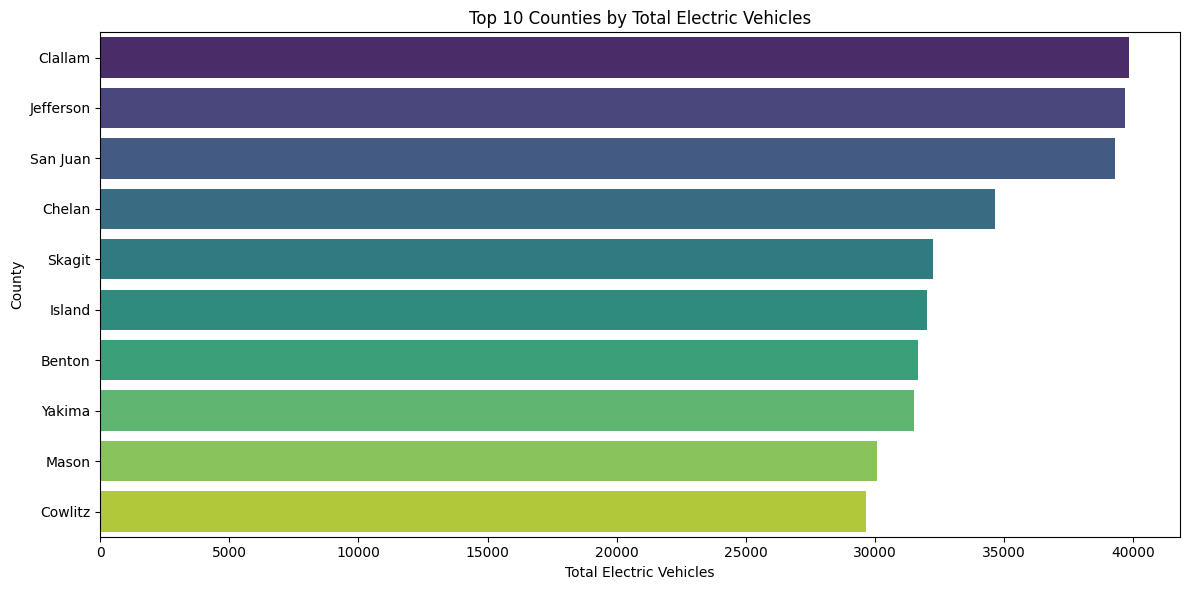

In [15]:
# Clean and convert relevant columns
df['Electric Vehicle (EV) Total'] = pd.to_numeric(df['Electric Vehicle (EV) Total'], errors='coerce')

# Group by county and sum the EV totals
df_grouped = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values(ascending=False).head(10)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=df_grouped.values, y=df_grouped.index, palette="viridis")
plt.title('Top 10 Counties by Total Electric Vehicles')
plt.xlabel('Total Electric Vehicles')
plt.ylabel('County')
plt.tight_layout()
plt.show()
